<a href="https://colab.research.google.com/github/alekrul/gt-health-management/blob/main/CMAPSS_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMPASS Time Series Analysis
This project aims to understand CMAPSS Nasa Jet Engine data. The goal is to use time series analysis to evaluate sensor data.

https://data.nasa.gov/Aerospace/CMAPSS-Jet-Engine-Simulated-Data/ff5v-kuh6/about_data

Reference: A. Saxena, K. Goebel, D. Simon, and N. Eklund, ‘Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation’, in the Proceedings of the 1st International Conference on Prognostics and Health Management (PHM08), Denver CO, Oct 2008.

In [26]:
import math
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
register_matplotlib_converters()
from time import time

sns.set()

## Import data
Data Set: FD001
Train trajectories: 100
Test trajectories: 100
Conditions: ONE (Sea Level)
Fault Modes: ONE (HPC Degradation)

Data Set: FD002
Train trajectories: 260
Test trajectories: 259
Conditions: SIX
Fault Modes: ONE (HPC Degradation)

Data Set: FD003
Train trajectories: 100
Test trajectories: 100
Conditions: ONE (Sea Level)
Fault Modes: TWO (HPC Degradation, Fan Degradation)

Data Set: FD004
Train trajectories: 248
Test trajectories: 249
Conditions: SIX
Fault Modes: TWO (HPC Degradation, Fan Degradation)


In [27]:
jet_data = pd.read_csv("/content/drive/MyDrive/Mestrado/Condition Based HM/Data/CMAPSSData/train_FD001.txt", sep=" ", header=None) #HPC Degradation
jet_rul = pd.read_csv("/content/drive/MyDrive/Mestrado/Condition Based HM/Data/CMAPSSData/RUL_FD001.txt", sep=" ", header=None)
test_data = pd.read_csv("/content/drive/MyDrive/Mestrado/Condition Based HM/Data/CMAPSSData/test_FD001.txt", sep = "\s+", header = None)
jet_data.columns = ["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5"
                    ,"sensor6","sensor7","sensor8","sensor9","sensor10","sensor11","sensor12","sensor13"
                    ,"sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
                    ,"sensor20","sensor21","sensor22","sensor23"]
test_data.columns = ["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5"
                    ,"sensor6","sensor7","sensor8","sensor9","sensor10","sensor11","sensor12","sensor13"
                    ,"sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
                    ,"sensor20","sensor21"]

jet_data.drop(['sensor22', 'sensor23'], axis=1, inplace=True)

jet_rul.columns = ['cycles', 'id']
jet_rul['id'] = jet_data['id'].unique()
jet_rul.set_index('id', inplace=True)

jet_id_and_rul = jet_data.groupby(['id'])[["id" ,"cycle"]].max()
jet_id_and_rul.set_index('id', inplace=True)

In [28]:
jet_data.head()

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [29]:
jet_rul.head()

,cycles
id,
1,112
2,98
3,69
4,82
5,91


In [30]:
jet_id_and_rul.head()

,cycle
id,
1,192
2,287
3,179
4,189
5,269


1. Index Names:"engine" : Engine No."cycle" : Time, In Cycles
2. Setting Names:"setting1" : Operation Setting 1"setting2" : Operation Setting 2"setting3" : Operation Setting 3
operational conditions: altitude (O-42K ft.), Mach number
(0-0.84), and TRA (20-100).
3. Sensor Names:"sensor1" : Fan Inlet Temperature (◦R)"sensor2" : LPC Outlet Temperature (◦R)"sensor3" : HPC Outlet Temperature (◦R)"sensor4" : LPT Outlet Temperature (◦R)"sensor5" : Fan Inlet Pressure (psia)"sensor6" : Bypass-Duct Pressure (psia)"sensor7" : HPC Outlet Pressure (psia)"sensor8" : Physical Fan Speed (rpm)"sensor9" : Physical Core Speed (rpm)"sensor10" : Engine Pressure Ratio(P50/P2)"sensor11" : HPC Outlet Static Pressure (psia)"sensor12" : Ratio of Fuel Flow to Ps30 (pps/psia)"sensor13" : Corrected Fan Speed (rpm)"sensor14" : Corrected Core Speed (rpm)"sensor15" : Bypass Ratio"sensor16" : Burner Fuel-Air Ratio"sensor17" : Bleed Enthalpy"sensor18" : Required Fan Speed"sensor19" : Required Fan Conversion Speed"sensor20" : High-Pressure Turbines Cool Air Flow"sensor21" : Low-Pressure Turbines Cool Air Flow

In [43]:
#take sensor 7 (HPC Outlet Pressure) engine 1 for case analysis
hpc_data = jet_data.loc[jet_data['id'] == 1, ['sensor7']]

In [44]:
hpc_data.head()

,sensor7
0,554.36
1,553.75
2,554.26
3,554.45
4,554.00


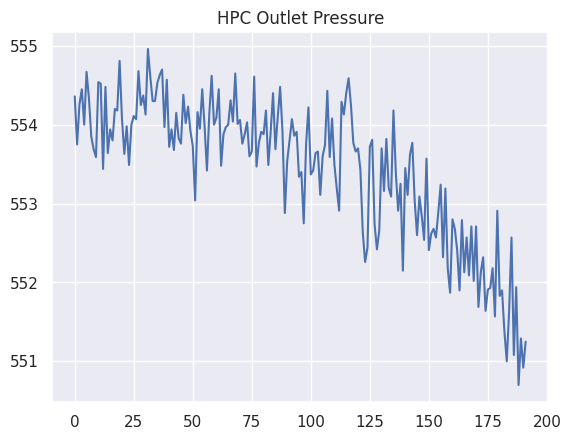

In [45]:
#plot sensor over time
plt.figure()
plt.plot(hpc_data)
plt.title('HPC Outlet Pressure')
plt.show()

From data we can visually see that it is non-stationary data. Stationary data needs to complain with those 3 conditions:
1) Mean constant
2) Standard deviation constant
3) No periodic behavior

The data looks like violates condition 1

##ACF

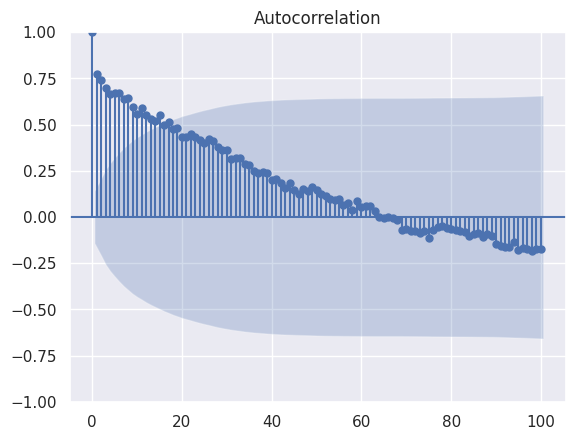

In [46]:
acf_plot = plot_acf(hpc_data, lags=100)

We're probably dealing with a Auto Regressive process (decaying acf)

##PACF

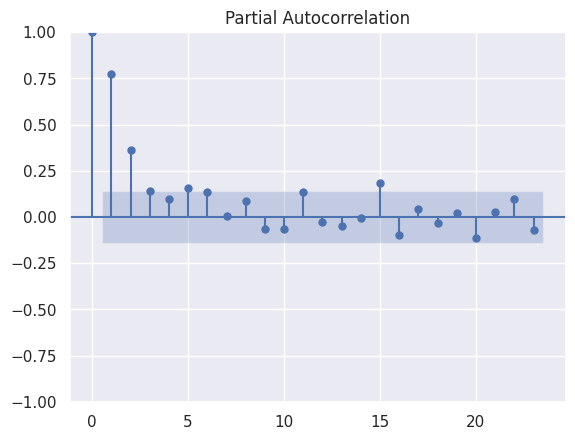

In [47]:
pacf_plot = plot_pacf(hpc_data)

Looks like two previous data points describe our data.
Maybe we can start with a AR model with lags 1 and 2

##Treat data

In [49]:
#hpc_first_diffs = hpc_data.values[1:] - hpc_data.values[:-1]
#hpc_first_diffs = np.concatenate([hpc_first_diffs, [0]])
hpc_first_diffs = hpc_data.diff().fillna(0)

In [50]:
hpc_data['FirstDifference'] = hpc_first_diffs

In [51]:
hpc_data

,sensor7,FirstDifference
0,554.36,0.00
1,553.75,-0.61
2,554.26,0.51
3,554.45,0.19
4,554.00,-0.45
...,...,...
187,551.94,0.86
188,550.70,-1.24
189,551.29,0.59
190,550.92,-0.37


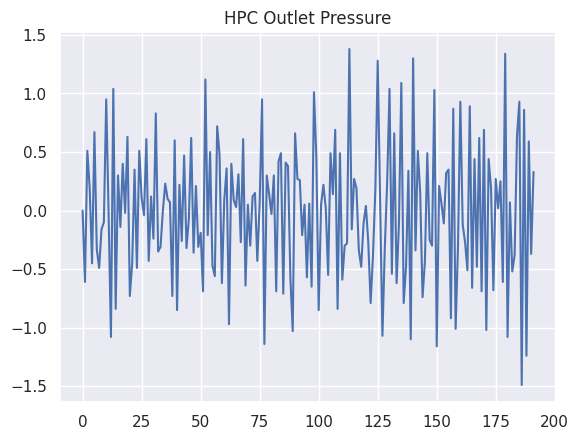

In [52]:
plt.figure()
plt.plot(hpc_data.FirstDifference)
plt.title('HPC Outlet Pressure')
plt.show()

Now looks like condition 1 is satisfied, but we can see a variation of standard deviation

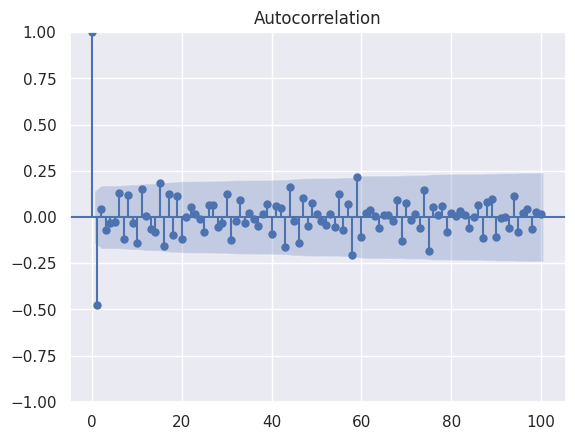

In [54]:
acf_plot = plot_acf(hpc_data.FirstDifference, lags=100)

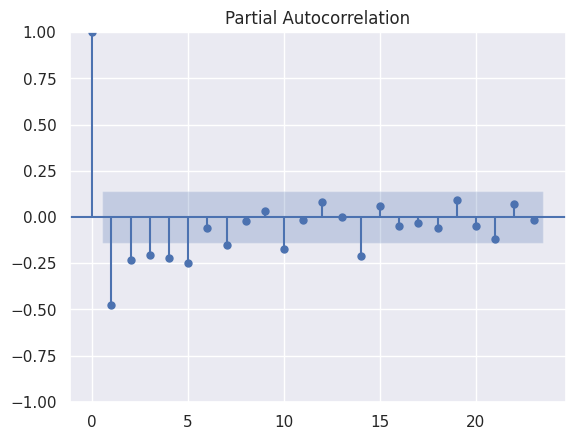

In [55]:
pacf_plot = plot_pacf(hpc_data.FirstDifference)

##Augmented Dickey Fuller Test

In [56]:
from statsmodels.tsa.stattools import adfuller

In [57]:
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [58]:
perform_adf_test(hpc_data.sensor7)

ADF Statistic: 1.844073
p-value: 0.998433


In [59]:
perform_adf_test(hpc_data.FirstDifference)

ADF Statistic: -5.291843
p-value: 0.000006


##AR Model

p-value < 0.5 is stationary
p-value >= 0.5 is non stationary

In [64]:
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA

In [62]:
train_cycle = 180

train_data = hpc_data.FirstDifference[:train_cycle]
test_data = hpc_data.FirstDifference[train_cycle+1:]

In [97]:
model = ARIMA(train_data, order=(5,1,0))

In [98]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.2173633575439453


In [99]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:        FirstDifference   No. Observations:                  190
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -159.949
Date:                Fri, 13 Dec 2024   AIC                            331.898
Time:                        11:01:33   BIC                            351.349
Sample:                             0   HQIC                           339.778
                                - 190                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3154      0.067    -19.505      0.000      -1.448      -1.183
ar.L2         -1.2244      0.105    -11.646      0.000      -1.430      -1.018
ar.L3         -1.0089      0.116     -8.676      0.0

In [100]:
predictions = model_fit.predict(train_cycle+1, 192)
residuals = test_data - predictions

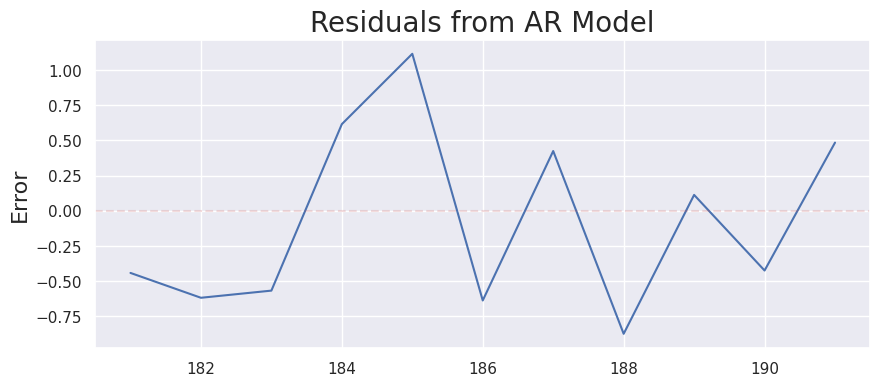

In [101]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Sensor 7')

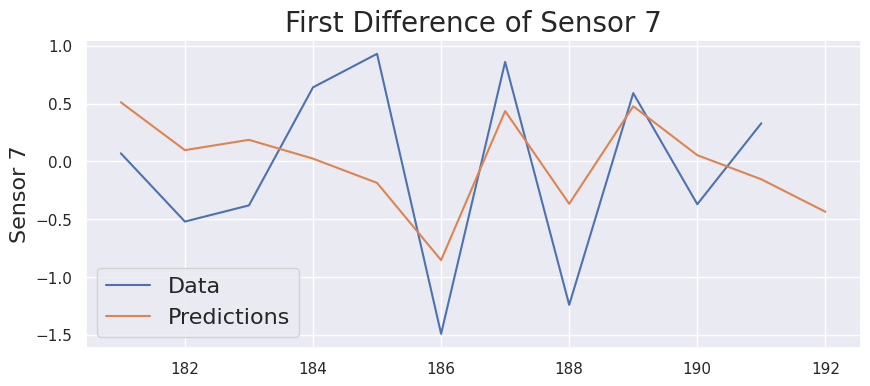

In [102]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('First Difference of Sensor 7', fontsize=20)
plt.ylabel('Sensor 7', fontsize=16)

In [103]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 0.6249849627134254


##Rolling forecasting origin

In [104]:
predictions_rolling = pd.Series()
for end_cycle in test_data.index:
  train_data = hpc_data.FirstDifference[:end_cycle-1]
  model = ARIMA(train_data, order=(5,1,0))
  model_fit = model.fit()
  pred = model_fit.predict(end_cycle)
  predictions_rolling.loc[end_cycle] = pred.loc[end_cycle]

In [105]:
residuals = test_data - predictions_rolling

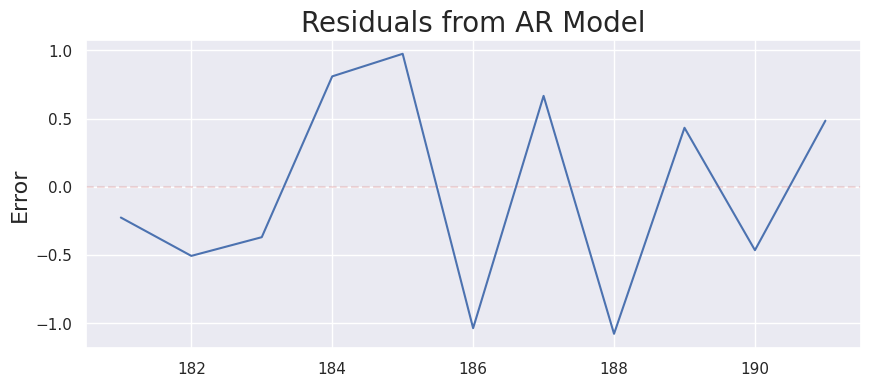

In [106]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Sensor 7')

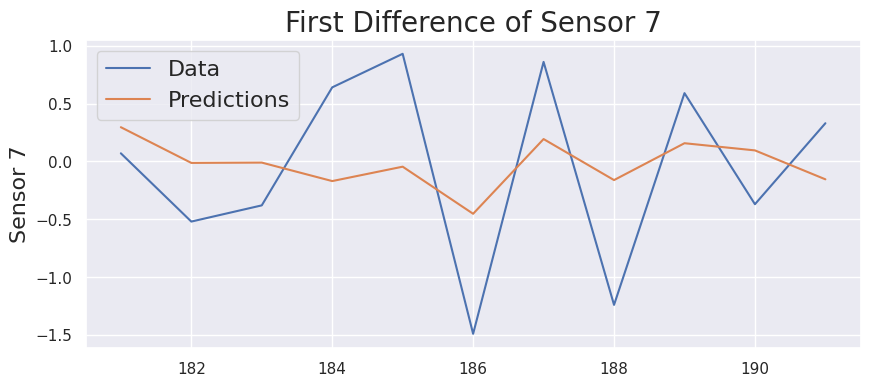

In [107]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions_rolling)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('First Difference of Sensor 7', fontsize=20)
plt.ylabel('Sensor 7', fontsize=16)

In [108]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 0.6990673876169108


##Moving Average Model

In [109]:
model = ARIMA(train_data, order=(0,0,2))

In [110]:
model_fit = model.fit()

In [111]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:        FirstDifference   No. Observations:                  190
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -123.980
Date:                Fri, 13 Dec 2024   AIC                            255.960
Time:                        11:04:33   BIC                            268.948
Sample:                             0   HQIC                           261.221
                                - 190                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0144      0.005     -2.838      0.005      -0.024      -0.004
ma.L1         -0.7859      0.072    -10.879      0.000      -0.928      -0.644
ma.L2         -0.0684      0.072     -0.948      0.3

In [112]:
predictions = model_fit.predict(train_cycle+1, 192)
residuals = test_data - predictions

Text(0, 0.5, 'Sensor 7')

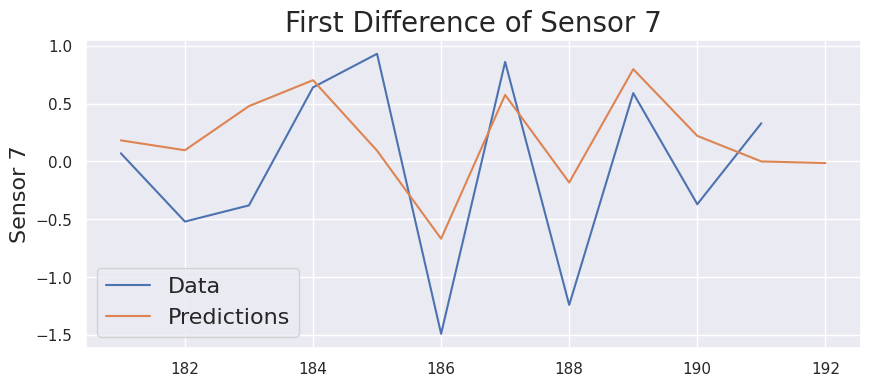

In [113]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('First Difference of Sensor 7', fontsize=20)
plt.ylabel('Sensor 7', fontsize=16)

In [114]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 0.6185956193237028


In [115]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.9749
